<a href="https://colab.research.google.com/github/gsgol/Pokemon_Gan/blob/main/VK_HSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Я попробую реализовать модель описанную в данной статье https://arxiv.org/pdf/1511.06434.pdf


# Добавим необходимые библиотеки


In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=24786bd6fb7900d7aaa5da30d9d7318adaeec13258994dee21e6023e6661f35b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
# библиотека для работы с операционной системой
import os

# основные библиотеки для первичного анализа и работы
import numpy as np
import pandas as pd

# библиотеки для работы с изображениями
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# библиотеки для построения модели и обработки изображений
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# Подключимся к нашему гугл диску на котором лежат изображения

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Перейдем к данным


In [5]:
# путь до данных
path = "/content/drive/MyDrive/images"

In [7]:
# возьмём несколько изображений чтобы посмотреть на них
image_samples = list()
num = 0
for i in range(9):
  sample_path =  os.path.join(path, os.listdir(path)[num])
  image_samples.append(cv2.imread(sample_path, cv2.IMREAD_UNCHANGED))
  num += 50


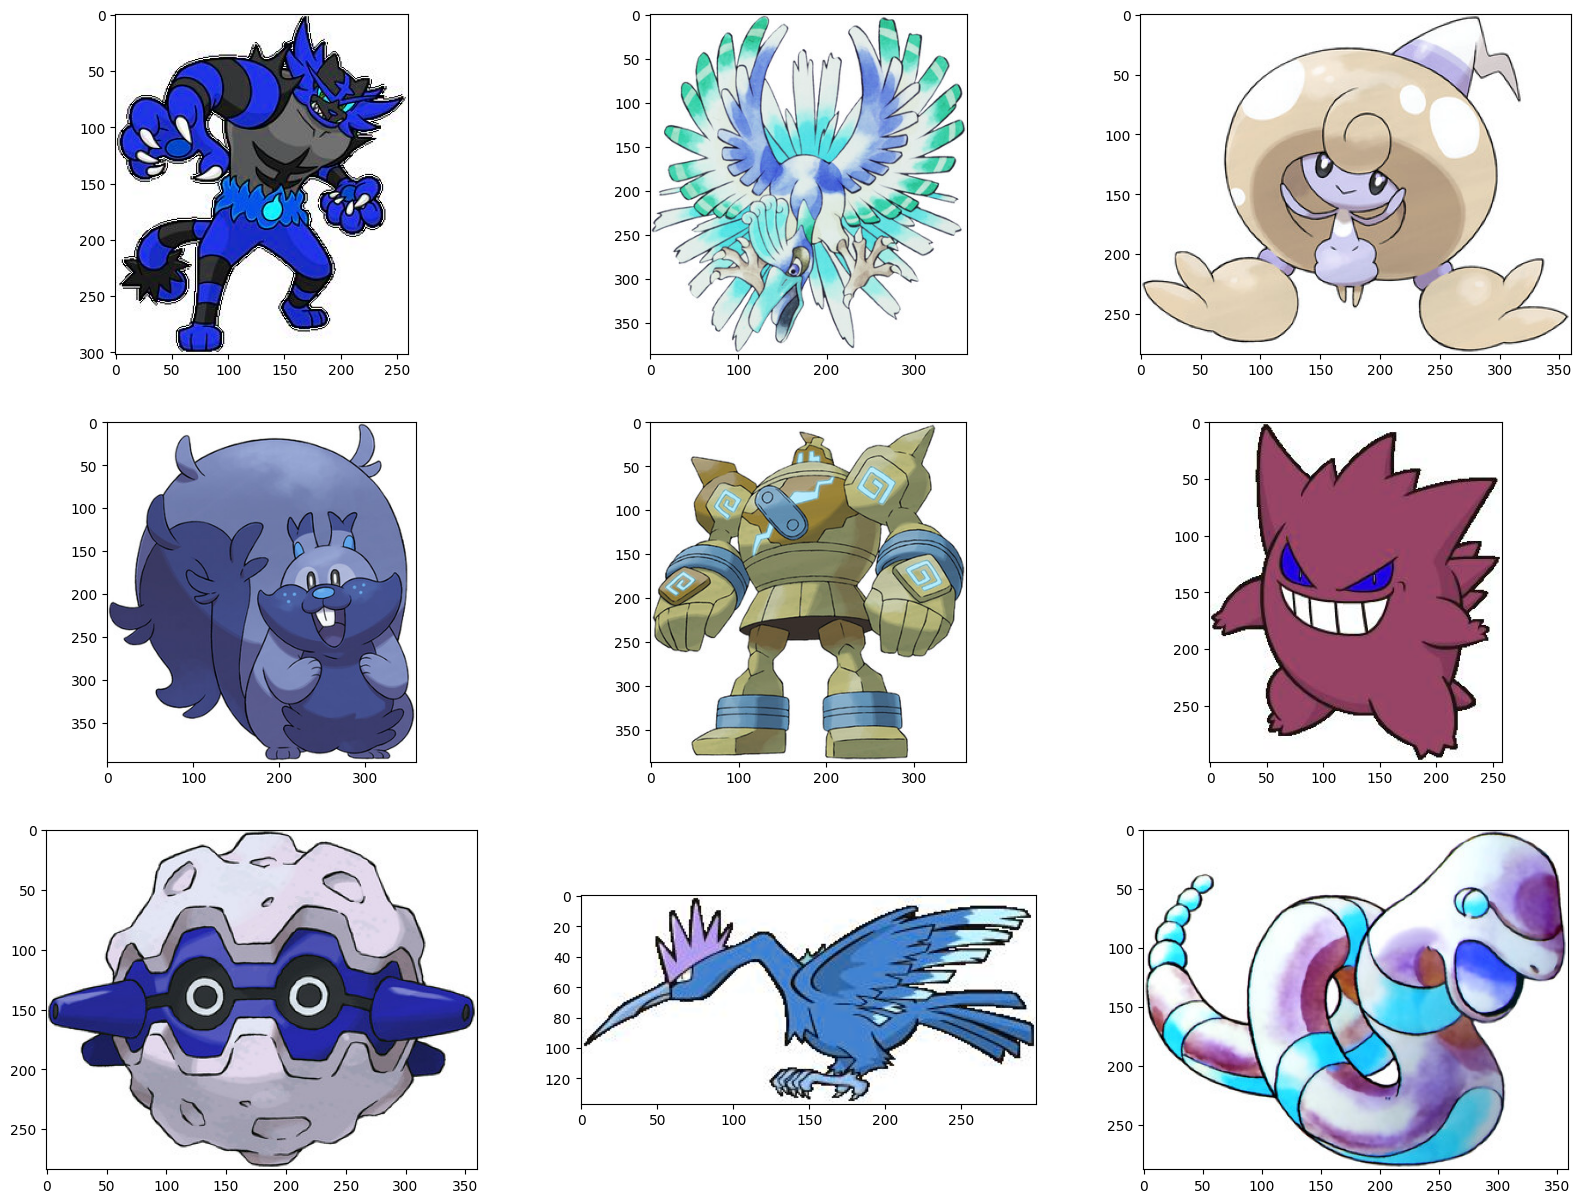

In [8]:
# посмотрим на наши изображения
n_rows, n_cols = 3, 3
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*5))
ax = ax.flatten()
for i in range(9):
  ax[i].imshow(image_samples[i])
plt.show()

In [9]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize((64, 64)),
        transforms.CenterCrop((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ])
batch_size = 128

In [10]:
class Dataset:

    def __init__(self, img_dir, transform=None):
        self.images = [
            os.path.join(img_dir, img_path) for img_path in os.listdir(img_dir)
        ]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


dataset = Dataset(img_dir=path, transform=transform)

In [11]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
class Generator(nn.Module):
    '''
    Generator class.
    Forward function takes a noise tensor of size Bx100
    and returns Bx3x256x256
    '''
    def __init__(self, noise_size=100):
        super().__init__()
        self.model = nn.Sequential(*[
            nn.ConvTranspose2d(in_channels=noise_size, out_channels=1024, stride=1, kernel_size=4, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(inplace=True),
            # 4x4
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, stride=2, kernel_size=4, padding=1, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            # 8x8
            nn.ConvTranspose2d(in_channels=512, out_channels=256, stride=2, kernel_size=4, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            # 16x16
            nn.ConvTranspose2d(in_channels=256, out_channels=128, stride=2, kernel_size=4, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            # 32x32
            nn.ConvTranspose2d(in_channels=128, out_channels=3, stride=2, kernel_size=4, padding=1, bias=False),
            nn.Tanh()
        ])


    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1, 1))
        return self.model(x)

In [13]:
class Discriminator(nn.Module):
    '''
    Discriminator class.
    Forward function takes a tensor of size BxCx256x256
    and return Bx1
    '''
    def __init__(self, in_channels=3):
        super().__init__()
        self.model = nn.Sequential(*[
            nn.Conv2d(in_channels=in_channels, out_channels=128, stride=2, kernel_size=5, padding=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, stride=2, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256, out_channels=512, stride=2, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=512, out_channels=1024, stride=2, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(num_features=1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=1, stride=4, kernel_size=5, padding=1, bias=False),
            nn.Sigmoid()
        ])

    def forward(self, x):
        x = self.model(x)
        return x.reshape((x.shape[0], 1))

In [14]:
generator = Generator()
discriminator = Discriminator()

In [15]:
LR = 0.0002
betas = (0.5, 0.999)

opt_g = torch.optim.Adam(generator.parameters(), lr=LR, betas=betas)
opt_d = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=betas)

criterion = nn.BCELoss()

In [ ]:
NUM_EPOCHS = 250

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

generator = generator.to(device)
discriminator = discriminator.to(device)

d_losses = []
g_losses = []
best_loss = np.infty

for epoch in range(1, NUM_EPOCHS+1):
    d_running_loss = 0.0
    g_running_loss = 0.0

    for real_images in dataloader:
        real_images = real_images.to(device)

        # Train D
        opt_d.zero_grad()
        # D(x)
        real_labels = torch.ones(real_images.shape[0], 1).to(device)
        real_preds = discriminator(real_images)
        real_loss = criterion(real_preds, real_labels)
        # D(G(z))
        z = torch.randn(real_images.shape[0], 100).to(device)
        fake_images = generator(z)
        fake_labels = torch.zeros(real_images.shape[0], 1).to(device)
        fake_preds = discriminator(fake_images)
        fake_loss = criterion(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        opt_d.step()

        d_running_loss += d_loss.item()

        # Train G
        opt_g.zero_grad()
        z = torch.randn(real_images.shape[0], 100).to(device)
        fake_images = generator(z)
        fake_preds = discriminator(fake_images)
        # fool discriminator
        g_loss = criterion(fake_preds, real_labels)

        g_loss.backward()
        opt_g.step()

        g_running_loss += g_loss.item()

    d_losses.append(d_running_loss/len(dataloader))
    g_losses.append(g_running_loss/len(dataloader))

    if epoch%10==0:
        print(f"Epoch {epoch}: D_loss={d_losses[-1]}, G_loss={g_losses[-1]}")
    if g_loss.item() <= best_loss:
       torch.save(generator.state_dict(), 'dcgan.pt')
       best_errD = d_loss.item()
       best_epoch = epoch
       best_loss = g_loss.item()
       print(f"Best loss = {best_loss} at epoch number = {epoch}")

cuda
Best loss = 13.741543365642428 at epoch number = 1
Best loss = 4.3535329177975655 at epoch number = 2
Best loss = 3.0437390208244324 at epoch number = 5
Best loss = 2.617651581764221 at epoch number = 8
Epoch 10: D_loss=0.7920491948723793, G_loss=3.086804282665253
Best loss = 2.5472480058670044 at epoch number = 12
Best loss = 1.771242767572403 at epoch number = 16
Epoch 20: D_loss=0.4882132330909371, G_loss=3.6560917854309083
Epoch 30: D_loss=0.5408195206895471, G_loss=4.734570866823196
Epoch 40: D_loss=0.42660751938819885, G_loss=4.818081277608871
Epoch 50: D_loss=0.1581873692572117, G_loss=4.36526460647583
Epoch 60: D_loss=0.13712457800284028, G_loss=4.686618852615356
Epoch 70: D_loss=0.39746400639414786, G_loss=5.490935349464417
Epoch 80: D_loss=0.21346645588055252, G_loss=5.770690095424652
Epoch 90: D_loss=0.5454766273498535, G_loss=5.590230995416642
Epoch 100: D_loss=0.12798189744353294, G_loss=4.966591572761535
Epoch 110: D_loss=0.5636426838114857, G_loss=4.9994382619857785

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [17]:
generator.eval()
with torch.no_grad():

    z = torch.randn(10, 100).to(device)
    generated_imgs = generator(z)

    # denormalize
    generated_imgs = generated_imgs*0.5 + 0.5


generated_imgs = generated_imgs.cpu().permute(0, 2, 3, 1).numpy()

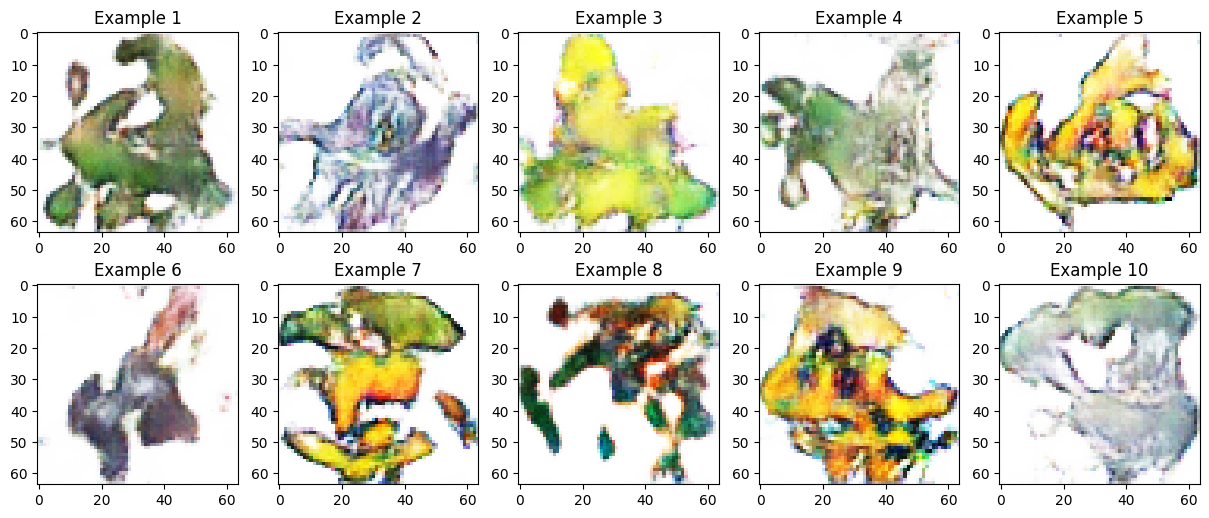

In [22]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

axs = axs.ravel()


for i in range(10):
    axs[i].imshow(generated_imgs[i])
    axs[i].set_title(f'Example {i+1}')

plt.show()

In [19]:
saved_model = Generator().to(device)
saved_model.load_state_dict(torch.load('/content/drive/MyDrive/dcgan.pt', map_location=device))
saved_model.eval()

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()

In [20]:

with torch.no_grad():

    z = torch.randn(10, 100).to(device)
    generated_imgs = saved_model(z)

    # denormalize
    generated_imgs = generated_imgs*0.5 + 0.5


generated_imgs = generated_imgs.cpu().permute(0, 2, 3, 1).numpy()

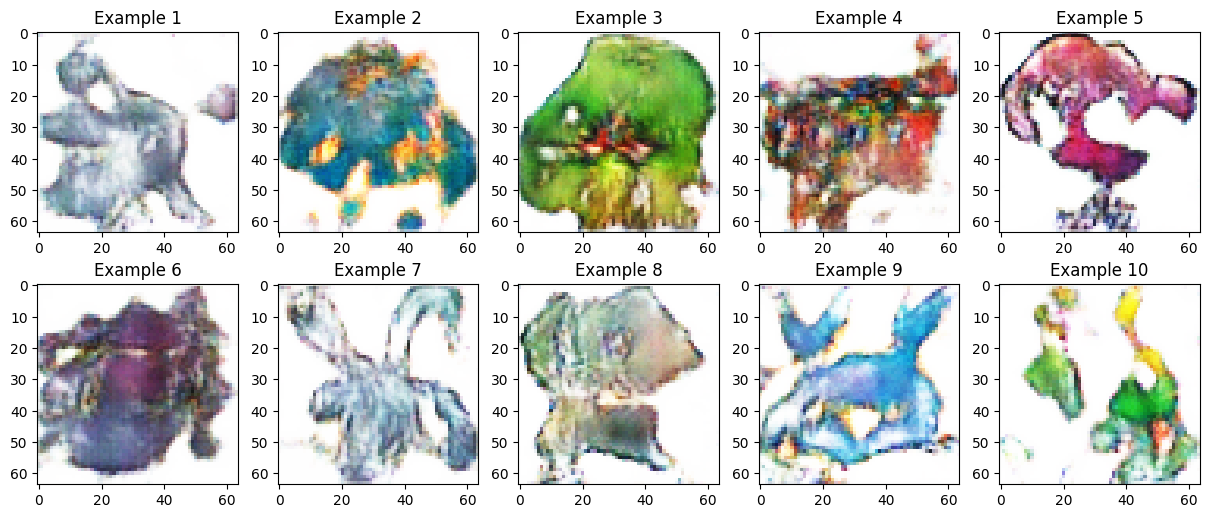

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

axs = axs.ravel()


for i in range(10):
    axs[i].imshow(generated_imgs[i])
    axs[i].set_title(f'Example {i+1}')

plt.show()